# MDOF PINN - n-step ahead prediction

## Problem overview

The example problem we solve here is the 3DOF nonlinear-stiffness oscillator defined in state space:
$$
\dot{\mathbf{z}} = \mathbf{A}\mathbf{z} + \mathbf{A}_n\mathbf{z}_n + \mathbf{H}\mathbf{f}
$$
where,
$$
\mathbf{z} = \left\{ x_1, x_2, ... , x_n, \dot{x}_1, \dot{x}_2, ... , \dot{x}_n \right\}^T, \quad
\mathbf{f} = \left\{ f_1, f_2, ... , f_n \right\}^T
$$
and $\mathbf{z}_n$ is the nonlinear state vector.
$$
\mathbf{A} = \begin{bmatrix} 0 & \mathbf{I} \\ -\mathbf{M}^{-1}\mathbf{K} & -\mathbf{M}^{-1}\mathbf{C} \end{bmatrix}, \quad
\mathbf{A}_n = \begin{bmatrix} 0 \\ -\mathbf{M}^{-1} \mathbf{K}_n \end{bmatrix}, \quad
\mathbf{H} = \begin{bmatrix} 0 \\ \mathbf{M}^{-1} \end{bmatrix}
$$
with the initial conditions
$$
\mathbf{x}(0) = \mathbf{x}_0~~,~~\dot{\mathbf{x}}(0) = \dot{\mathbf{x}}_0~~,~~\mathbf{z}_0 = \{\mathbf{x}_0,\dot{\mathbf{x}}_0\}^T
$$

As an example, for a 3DOF system with cubic nonlinearities, fixed at the first degree of freedom:
$$
\mathbf{z}_n = g_n(\mathbf{z}) = \left\{ x_1^3, (x_2-x_1)^3, (x_3-x_2)^3 \right\}^T, \quad
\mathbf{K}_n = \begin{bmatrix} k_{n,1} & -k_{n,2} & 0 \\ 0 & k_{n,2} & -k_{n,3} \\ 0 & 0 & k_{n,3} \end{bmatrix}
$$

The aim is to predict the state at some time horizon ahead, using the previous state and force;
$$
\mathbf{z}^{(n+1)} = \mathcal{F}(\mathbf{z}^{(n)}, \Delta t, f)
$$

In [3]:
from mdof_osa_pinn import osa_pinn_mdof, osa_mdof_dataset
import dynasim
from mdof_solutions import gen_ndof_cantilever
# from aux_funcs import osa_parser

import numpy as np
import torch
from torch.utils.data import DataLoader

from scipy.stats import qmc
import scipy
import string

from tqdm import tqdm
from tqdm.auto import tqdm as tqdma

import matplotlib.pyplot as plt
from IPython import display
%matplotlib inline

%load_ext autoreload
%autoreload 2

print(scipy.__version__)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.7.3


/opt/homebrew/Caskroom/miniforge/base/envs/pytorch2-py310/lib/python3.10/site-packages/dynasim/base.py:81: UserWarning: No initial conditions provided, proceeding with zero initial state
  warnings.warn('No initial conditions provided, proceeding with zero initial state', UserWarning)


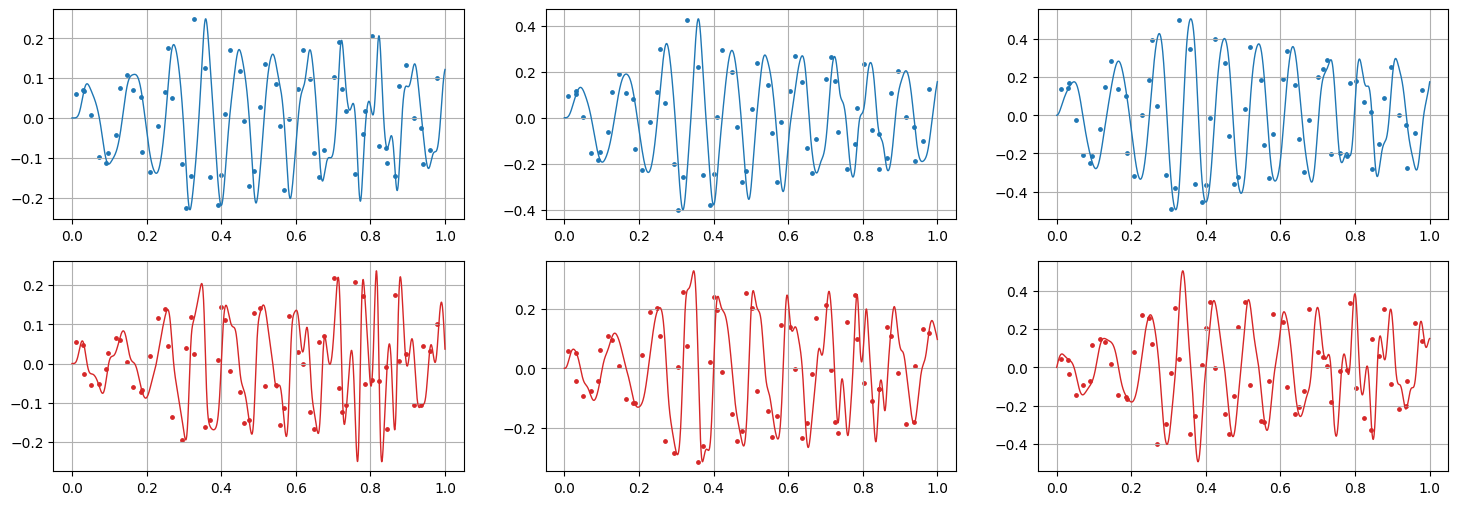

In [4]:
nt = 2048
fs = 50
dt = 1/fs
time = np.arange(0, nt*dt, dt)

F0 = 1.0  # N
n_dof = 3

test_args = {
    'num_col_per_time' : 6,
    'nonlin_type' : 'duffing_stiffness'
}

# set physical parameters
k_ = np.array([10.0, 15.0, 10.0])
c_ = np.array([0.25, 0.3, 0.2])
m_ = np.array([1.0, 1.0, 1.0])
kn_ = np.array([30.0, 15.0, 20.0])
cn_ = np.array([1.0, 1.0, 1.0])

# create nonlinearity
match test_args['nonlin_type']:
    case 'vanDerPol_damping':
        system_nonlin = dynasim.nonlinearities.vanDerPol(cn_, dofs=n_dof)
    case 'exponent_damping':
        system_nonlin = dynasim.nonlinearities.exponent_damping(cn_, exponent=0.5, dofs=n_dof)
    case 'duffing_stiffness':
        system_nonlin = dynasim.nonlinearities.exponent_stiffness(kn_, exponent=3, dofs=n_dof)

# instantiate system
system = dynasim.systems.mdof_cantilever(m_, c_, k_, dofs=n_dof, nonlinearity=system_nonlin)

true_params = {
    'm_' : system.m_.copy(),
    'c_' : system.c_.copy(),
    'k_' : system.k_.copy(),
    'kn_' : kn_.copy(),
    'cn_' : cn_.copy()
}

excitations = [None] * n_dof
excitations[-1] = dynasim.actuators.sine_sweep(w_l = 0.5, w_u = 6.0, F0 = 1.0)

system.excitations = excitations

data = system.simulate(time, z0=None)

t_span = torch.tensor(time.reshape(-1,1), dtype=torch.float32)
xx, vv = torch.tensor(data['x'].T, dtype=torch.float32), torch.tensor(data['xdot'].T, dtype=torch.float32)
f = torch.tensor(system.f.T, dtype=torch.float32)

ground_truth = {
    "t" : time.reshape(-1, 1),
    "x_hat" : xx,
    "v_hat" : vv,
    "f_hat" : f
}

device = torch.device("cpu")
batch_size = 64
data_config = {
    'subsample' : 32,
    'nct' : test_args['num_col_per_time']
}
dataset = osa_mdof_dataset(t_span, xx, vv, f, data_config, device=device)
phases = ['full', 'train', 'val']
full_dataset = torch.utils.data.random_split(dataset, [1.0])
train_size = 0.7; val_size = 0.3
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)#, multiprocessing_context='fork')

if n_dof > 3:
    sub_rows = n_dof // 3 + int((n_dof%3)!=0)
    sub_cols = 3
else:
    sub_rows = 1
    sub_cols = n_dof

fig, axs = plt.subplots(2*sub_rows, sub_cols, figsize=(6*sub_cols, 6*sub_rows))
p_count = 0
for j in range(sub_rows):
    for i in range(sub_cols):
        axs[j*2, i].plot(ground_truth['t'][:,0]/dataset.alphas['t'], ground_truth['x_hat'][:,p_count]/dataset.alphas['x'], color="tab:blue", linewidth=1.0, linestyle='-')
        axs[j*2, i].scatter(dataset.obs_data[:, -1].detach(), dataset.obs_data[:, p_count].detach(), color="tab:blue", s=6)
        axs[j*2, i].grid()

        axs[j*2+1, i].plot(ground_truth['t'][:,0]/dataset.alphas['t'], ground_truth['v_hat'][:,p_count]/dataset.alphas['v'], color="tab:red", linewidth=1.0, linestyle='-')
        axs[j*2+1, i].scatter(dataset.obs_data[:, -1].detach(), dataset.obs_data[:, n_dof + p_count].detach(), color="tab:red", s=6)
        axs[j*2+1, i].grid()
        
        p_count += 1
        if p_count == n_dof:
            break

Normalise and create some plotting functions

In [ ]:
t_hat_col, alpha_t = normalise(time, "range")
x_hat_col, alpha_x = normalise(xx, "range", "all")
v_hat_col, alpha_v = normalise(vv, "range", "all")
z_hat_col = np.concatenate((x_hat_col, v_hat_col), axis=1)
f_hat_col, alpha_f = normalise(F, "range", "all")

# slice out a number of points
sampler = qmc.Sobol(d=1, seed=43810)
sub_ind = np.sort(qmc.Sobol(d=1, seed=43810).integers(l_bounds=nt, n=int(nt/32)), axis=0).squeeze()
# sub_ind = np.arange(0, int(nt/1), 2)

t_hat_obs = t_hat_col[sub_ind]
x_hat_obs = x_hat_col[sub_ind,:]
v_hat_obs = v_hat_col[sub_ind,:]
z_hat_obs = z_hat_col[sub_ind, :]
f_hat_obs = f_hat_col[sub_ind,:]

fig, axs = plt.subplots(3*sub_rows,sub_cols,figsize=(4*sub_cols,8*sub_rows))
p_count = 0
for j in range(sub_rows):
    for i in range(sub_cols):
        axs[j*3,i].plot(t_hat_col, x_hat_col[:,i], color="tab:blue", label="Displacement", linewidth=1.0, linestyle='-')
        axs[j*3,i].scatter(t_hat_obs, x_hat_obs[:,i], color="tab:blue", label="Observation data", s=6)
        axs[j*3,i].grid()
        axs[j*3,i].legend()

        axs[j*3+1,i].plot(t_hat_col, v_hat_col[:,i], color="tab:red", label="Velocity", linewidth=1.0, linestyle='-')
        axs[j*3+1,i].scatter(t_hat_obs, v_hat_obs[:,i], color="tab:red", label="Observation data", s=6)
        axs[j*3+1,i].grid()
        axs[j*3+1,i].legend()

        axs[j*3+2,i].plot(t_hat_col, f_hat_col[:,i], color="tab:gray", label="Forcing", linewidth=1.0, linestyle='-')
        axs[j*3+2,i].scatter(t_hat_obs, f_hat_obs[:,i], color="tab:gray", label="Observation data", s=6)
        axs[j*3+2,i].legend()

        p_count += 1
        if p_count == n_dof:
            break

In [ ]:
alphabet = list(string.ascii_uppercase)
mosaic_key = ''
alph_count = 0
for j in range(sub_rows):
    mosaic_key += ''.join(alphabet[alph_count:alph_count+sub_cols]) + ';' + ''.join(alphabet[alph_count+sub_cols:alph_count+2*sub_cols]) + ';'
    alph_count += 2*sub_cols
mosaic_key += ''.join([alphabet[alph_count]]*sub_cols)
print(mosaic_key)

def plot_joint_loss_hist(ax,loss_hist):
    n_epoch = len(loss_hist)
    labels = ["L_obs", "L_ic", "L_cc", "L_ode", "L"]
    colors = ["tab:blue", "tab:red", "tab:green", "tab:cyan", "black"]
    # labels = ["L_obs", "L_ic", "L_ode", "L_ed_b", "L_ed_p", "L"]
    # colors = ["tab:blue", "tab:red", "tab:green", "tab:orange", "tab:purple", "black"]
    ax.cla()
    for i in range(len(labels)):
        ax.plot(np.arange(1,n_epoch+1),loss_hist[:,i],color=colors[i],label=labels[i])
    ax.set_yscale('log')
    ax.legend()

def plot_result(axs_m, ground_truth, obs_data, prediction, alphas):
    for ax in axs_m:
        axs_m[ax].cla()
    axs_top_list = []
    for j in range(sub_rows):
        axs_top_list.append([axs_m[alphabet[3*sub_cols*j+i]] for i in range(sub_cols)])
        axs_top_list.append([axs_m[alphabet[3*sub_cols*j+sub_cols+i]] for i in range(sub_cols)])
        axs_top_list.append([axs_m[alphabet[3*sub_cols*j+2*sub_cols+i]] for i in range(sub_cols)])
    axs_top = np.array(axs_top_list)

    plot_keys = ["x_hat", "v_hat", "f_hat"]
    plot_cols = ["tab:blue", "tab:red", "tab:gray"]
    alpha_keys = ["x", "v", "f"]
    p_count = 0
    for j in range(sub_rows):
        for i in range(sub_cols):
            for n in range(3):
                if n < 2:
                    axs_top[j*3+n,i].plot(obs_data["t_hat"].detach()*alphas["t"], obs_data[plot_keys[n]][:,p_count]*alphas[alpha_keys[n]], color="tab:olive", linewidth=1, alpha=0.8, label='Observation data')
                axs_top[j*3+n,i].plot(ground_truth["t"], ground_truth[plot_keys[n]][:,p_count], color="grey", linewidth=2, alpha=0.5, label="Exact solution")
                axs_top[j*3+n,i].plot(prediction["t_hat"]*alphas["t"], prediction[plot_keys[n]][:,p_count]*alphas[alpha_keys[n]], color=plot_cols[n], linewidth=2, alpha=0.8, linestyle='--', label="Prediction")
                xL = np.amax(ground_truth["t"])
                yL = np.amax(np.abs(ground_truth[plot_keys[n]][:,p_count]))
                axs_top[j*2+n,i].set_xlim(-0.05*xL, 1.05*xL)
                axs_top[j*2+n,i].set_ylim(-1.1*yL, 1.1*yL)

            p_count += 1
            if p_count == n_dof:
                break

device = torch.device("cpu")

col_data = {
    "t_hat" : torch.Tensor(t_hat_col).reshape(-1,1).float().to(device).requires_grad_(),
    "f_hat" : torch.Tensor(f_hat_col).float().to(device).requires_grad_()
}

prediction = {
    "t_hat" : t_hat_col,
    "x_hat" : None,
    "v_hat" : None,
    "f_hat" : None
}

obs_data_all = {
    "t_hat" : t_hat_obs,
    "x_hat" : x_hat_obs,
    "v_hat" : v_hat_obs,
    "z_hat" : z_hat_obs,
    "f_hat" : f_hat_obs
}

## PINN

Neural network predicts within a time horizon, given the current state and force:
$$
\mathcal{N}_{\mathbf{z}}(\mathbf{z}_0,t,\mathbf{f}_0),~~\mathcal{N}_{\mathbf{z}_n}=g_n(\mathcal{N}_{\mathbf{z}}) \qquad 
\mathbf{R} = \partial_t \mathcal{N}_{\mathbf{z}} - \mathbf{A} \mathcal{N}_{\mathbf{z}} - \mathbf{A}_n \mathcal{N}_{\mathbf{z}_n} - \mathbf{H}\mathbf{f}
$$

$$
\mathcal{L}(x_0,v_0,t,f_0;\mathbf{\theta}) := \mathcal{L}_{obs} + \mathcal{L}_{ic} + \Lambda\mathcal{L}_{ode}
$$

$$
\mathcal{L}_{obs} = \langle \hat{\mathbf{z}}^* - \mathcal{N}_{\hat{\mathbf{z}}} \rangle _{\Omega\in\{t=T\}}
% \mathcal{L}_{cc} = \sum_{j=1}^{N_{d}} \left\langle \alpha_{\dot{x}}\mathcal{N}_{\hat{\dot{x}}_j} - \frac{\alpha_x}{\alpha_t}\partial_{\hat{t}} \mathcal{N}_{\hat{x}_j} \right\rangle _{\Omega_d}
$$
$$
\mathcal{L}_{ic} = \sum_{j=1}^{N_{d}}\left[ 
\left\langle \alpha_{\dot{x}}\hat{\dot{x}}_{j,0} - \frac{\alpha_x}{\alpha_t}\partial_{\hat{t}}\mathcal{N}_{\hat{x}_j} \right\rangle ~~ + ~~
\left\langle \alpha_{x}\hat{x}_{j,0} - \alpha_x\mathcal{N}_{\hat{x}_j} \right\rangle ~~ + ~~
\left\langle \alpha_{\dot{x}}\hat{\dot{x}}_{j,0} - \alpha_{\dot{x}}\mathcal{N}_{\hat{\dot{x}}_j} \right\rangle
\right] _{\Omega\in\{t=0\}}
$$
$$
\mathcal{L}_{cc} = \sum_{j=1}^{N_{d}} \left\langle \mathbf{R}[j,:] \right\rangle _{\Omega_p}, \qquad
\mathcal{L}_{ode} = \sum_{j=1}^{N_{d}} \left\langle \mathbf{R}[N_d+j,:] \right\rangle _{\Omega_p}
$$
where,
$$ \mathcal{N}_{\bullet} = \mathcal{N}_{\bullet}(\mathbf{z};\mathbf{\theta}), \qquad 
\partial_{*}\bullet = \frac{\partial\bullet}{\partial *}, \qquad 
\partial^2_{*}\bullet = \frac{\partial^2\bullet}{\partial *^2}, \qquad
\langle\bullet\rangle _{\Omega_{\kappa}} = \frac{1}{N_{\kappa}}\sum_{t\in\Omega_{\kappa}}\left|\left|\bullet\right|\right|^2 $$

ODE loss function comes from including the normalisation of the parameters, then choosing the suitable range to aid optimisation.

$$
\frac{1}{\alpha_t^2} \partial^2_{\hat{t}}\hat{x} + 
\tilde{c}\frac{1}{\alpha_t}\partial_{\hat{t}}\hat{x} + 
\tilde{k} \hat{x} - 
\frac{\alpha_F}{\alpha_x} \hat{F} = 0 
\quad \rightarrow \quad 
\hat{m} \partial^2_{\hat{t}}\hat{x} + 
\hat{c} \partial_{\hat{t}}\hat{x} + 
\hat{k}\hat{x} - \eta\hat{F} = 0
$$
To scale loss function in a physically meaningful way, multiply the loss function by any of the following:
$$
\Lambda = 1, \alpha_t, \alpha_t^2, \alpha_x^, \alpha_F^{-1}
$$

In [ ]:
## Organise Data
n_obs = obs_data_all["z_hat"].shape[0] - 1
z0_obs = obs_data_all["z_hat"][:-1, :]
T_obs = torch.zeros((n_obs, 1))
for i in range(n_obs):
    T_obs[i] = obs_data_all["t_hat"][i+1] - obs_data_all["t_hat"][i]
if obs_data_all["f_hat"] is not None:
    f_obs = obs_data_all["f_hat"][:-1, :]
zk_obs = obs_data_all["z_hat"][1:, :]

# collocation set
t_col_list = []
t_pred_list = []
z0_col_list = []
f_col_list = []
for k in range(n_obs):
    t_span_k = np.arange(0.0, T_obs[k].item(), dt/alpha_t)
    nct_k = t_span_k.shape[0]
    t_col_list.extend(t_span_k.tolist())
    t_pred_list.extend((t_span_k + obs_data_all["t_hat"][k].item()).tolist())
    z0_col_list.extend([z0_obs[k,:].tolist()]*nct_k)
    f_col_list.extend([f_obs[k,:].tolist()]*nct_k)
t_col = np.array(t_col_list)
t_pred = np.array(t_pred_list)
z0_col = np.array(z0_col_list)
f_col = np.array(f_col_list)

In [ ]:
alpha_c = 1.0
alpha_k = 10.0
alpha_kn = 1.0
alphas = {
    "c" : 1.0,
    "k" : 1.0,
    "kn" : 1.0,
    "t" : alpha_t,
    "x" : alpha_x,
    "v" : alpha_v,
    "f" : alpha_f
}

nct = 4  # number of collocation points in time window

torch.manual_seed(123)

osa_config = {
    "n_input" : 3*n_dof + 1,
    "n_output" : 2*n_dof,
    "n_hidden" : 16,
    "n_layers" : 4,
    "n_dof" : n_dof,
    "nct" : nct,
    "nonlinearity" : nonlin_state_transform,
    "phys_params" : {
        "m_" : {
            "type" : "constant",
            "value" : torch.tensor(system.m_, dtype=torch.float32)
        },
        "c_" : {
            "type" : "variable",
            "value" : torch.tensor(system.c_, dtype=torch.float32)
        },
        "k_" : {
            "type" : "variable",
            "value" : torch.tensor(system.k_, dtype=torch.float32)
        },
        "kn_" : {
            "type" : "variable",
            "value" : torch.tensor(kn_, dtype=torch.float32)
        },
    },
    "param_func" : gen_ndof_cantilever,
    "alphas" : alphas,
    "device" : device
}

# configure PINN
osa_model = osa_pinn_mdof(osa_config)
t_pred = osa_model.set_colls_and_obs(t_data, x_data, v_data, F_data)
prediction["t_hat"] = t_pred.detach()

# configure optimiser
learning_rate = 5e-4
betas = (0.99,0.999)
optimizer = torch.optim.Adam(osa_model.parameters(), lr=learning_rate, betas=betas)

fig, axs = plt.subplot_mosaic(
    mosaic_key,
    figsize=(18,16),
    facecolor='w'
)

print_step = 1000
loss_hist=[]
lambds = {
    'obs' : 100.0,
    'ic' : 1.0,
    'ode' : 5000.0,
    'cc' : 1000.0,
}

epochs = int(1e6)
for i in tqdm(range(epochs)):

    optimizer.zero_grad()
    loss, losses = osa_model.loss_func(lambds)
    loss_hist.append([loss_it.item() for loss_it in losses] + [loss.item()])
    loss.backward()
    optimizer.step()

    if (i+1) % print_step == 0:

        z_pred = osa_model.predict()

        prediction["x_hat"] = z_pred.detach()[:,:n_dof]
        prediction["v_hat"] = z_pred.detach()[:,n_dof:]

        plot_result(axs, ground_truth, data, prediction, alphas)

        plot_joint_loss_hist(axs[alphabet[2*n_dof]], np.array(loss_hist))

        display.clear_output(wait=True)
        display.display(plt.gcf())
        match osa_model.param_type:
            case "constant":
                tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss_hist[i][-1]))
            case "variable":
                tqdma.write("Epoch : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f" % (i+1,loss_hist[i][-1],osa_model.phys_params[0]*alphas['c'],osa_model.phys_params[1]*alphas['k']))

display.clear_output()
match osa_model.param_type:
    case "constant":
        tqdma.write("Epoch : %d ---- Loss: %.2e" % (i+1,loss_hist[i][-1]))
    case "variable":
        tqdma.write("Epoch : %d ---- Loss: %.2e \nc_tild: %.4f ---- k_tild: %.4f" % (i+1,loss_hist[i][-1],osa_model.phys_params[0]*alphas['c'],osa_model.phys_params[1]*alphas['k']))
        

In [ ]:
result_data = {
    'epoch' : i,
    # 'gt_system' : system,
    'osa_config' : osa_config,
    'model' : osa_model.state_dict(),
    'loss' : loss_hist,
    'ground_truth' : ground_truth,
    'data' : data,
    'prediction' : prediction,
    'alphas' : alphas
}

torch.save(result_data, 'results/osa_duffing_mdof.pth')